# 곡 추천 시스템 구축

---
사용하는 데이터베이스: Million Songs Dataset 
---


소스: http://labrosa.ee.columbia.edu/millionsong/

논문: http://ismir2011.ismir.net/papers/OS6-1.pdf


이 노트에서는 아래로부터  10,000 개의 곡을 선택한 데이터베이스를 사용합니다.

https://github.com/turi-code/tutorials/blob/master/notebooks/recsys_rank_10K_song.ipynb

In [2]:
%matplotlib inline

import pandas
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import Recommenders as Recommenders
import Evaluation as Evaluation

# 곡 데이터 불러오기

In [3]:
#user_id-song_id-listen_count 를 읽어옵니다.
#외부 소스로부터 다운로드 받는데 시간이 걸릴 수 있습니다.
triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

song_df_1 = pandas.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

#곡의 메타데이터를 읽어옵니다.
song_df_2 =  pandas.read_csv(songs_metadata_file)

#추천 시스템의 입력 데이터 프레임을 생성하기 위해 두 개의 데이터 프레임을 병합합니다.
song_df = pandas.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left") 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


# 데이터 살펴보기

곡 데이터는 한 사용자의 청취 횟수와 곡의 세부사항을 담고 있습니다.

In [4]:
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


## 데이터셋의 길이

In [5]:
len(song_df)

2000000

## 서브셋 생성하기

In [6]:
song_df = song_df.head(10000)

#곡 제목과 작곡가명을 병합하여 하나의 열로 만듭니다.
song_df['song'] = song_df['title'].map(str) + " - " + song_df['artist_name']

## 데이터셋에서 가장 인기 있는 곡 찾기

In [7]:
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
3660,Sehr kosmisch - Harmonia,45,0.45
4678,Undo - Björk,32,0.32
5105,You're The One - Dwight Yoakam,32,0.32
1071,Dog Days Are Over (Radio Edit) - Florence + Th...,28,0.28
3655,Secrets - OneRepublic,28,0.28
4378,The Scientist - Coldplay,27,0.27
4712,Use Somebody - Kings Of Leon,27,0.27
3476,Revelry - Kings Of Leon,26,0.26
1387,Fireflies - Charttraxx Karaoke,24,0.24
1862,Horn Concerto No. 4 in E flat K495: II. Romanc...,23,0.23


## 데이터셋에서 사용자 수 찾기

In [8]:
users = song_df['user_id'].unique()

In [9]:
len(users)

365

## 퀴즈 1. 데이터셋의 곡 수 찾기

In [10]:
###이곳에 코드를 입력
songs = song_df['song'].unique()
len(songs)

5151

# 곡 추천 시스템 생성하기

In [11]:
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)
print(train_data.head(5))

                                       user_id             song_id  \
7389  94d5bdc37683950e90c56c9b32721edb5d347600  SOXNZOW12AB017F756   
9275  1012ecfd277b96487ed8357d02fa8326b13696a5  SOXHYVQ12AB0187949   
2995  15415fa2745b344bce958967c346f2a89f792f63  SOOSZAZ12A6D4FADF8   
5316  ffadf9297a99945c0513cd87939d91d8b602936b  SOWDJEJ12A8C1339FE   
356   5a905f000fc1ff3df7ca807d57edb608863db05d  SOAMPRJ12A8AE45F38   

      listen_count                 title  \
7389             2      Half Of My Heart   
9275             1  The Beautiful People   
2995             1     Sanctify Yourself   
5316             4     Heart Cooks Brain   
356             20                 Rorol   

                                                release      artist_name  \
7389                                     Battle Studies       John Mayer   
9275             Antichrist Superstar (Ecopac Explicit)   Marilyn Manson   
2995                             Glittering Prize 81/92     Simple Minds   
5316  Ever

## 인기도 기반의  간단한 추천 클래스 (블랙박스로도 사용 가능)

In [12]:
#Recommenders.popularity_recommender_py

### 인기도 기반 추천 클래스의 인스턴스 생성

In [13]:
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

### 인기도 기반 모델을 이용한 예측

In [14]:
user_id = users[5]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Sehr kosmisch - Harmonia,37,1.0
4083,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Undo - Björk,27,2.0
931,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,4bd88bfb25263a75bbdd467e74018f4ae570e5df,You're The One - Dwight Yoakam,24,4.0
3034,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Revelry - Kings Of Leon,21,5.0
3189,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Secrets - OneRepublic,21,6.0
4112,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Use Somebody - Kings Of Leon,21,7.0
1207,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Fireflies - Charttraxx Karaoke,20,8.0
1577,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hey_ Soul Sister - Train,19,9.0
1626,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


### 퀴즈 2: 인기도 기반 모델로 다른 사용자 ID 에 대해 예측하기 (첫 번째 사용자와 차이점 주목)

In [15]:
###이곳에 코드 입력
user_id = users[8]
pm.recommend(user_id)


,user_id,song,score,Rank
3194,9bb911319fbc04f01755814cb5edb21df3d1a336,Sehr kosmisch - Harmonia,37,1.0
4083,9bb911319fbc04f01755814cb5edb21df3d1a336,Undo - Björk,27,2.0
931,9bb911319fbc04f01755814cb5edb21df3d1a336,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,9bb911319fbc04f01755814cb5edb21df3d1a336,You're The One - Dwight Yoakam,24,4.0
3034,9bb911319fbc04f01755814cb5edb21df3d1a336,Revelry - Kings Of Leon,21,5.0
3189,9bb911319fbc04f01755814cb5edb21df3d1a336,Secrets - OneRepublic,21,6.0
4112,9bb911319fbc04f01755814cb5edb21df3d1a336,Use Somebody - Kings Of Leon,21,7.0
1207,9bb911319fbc04f01755814cb5edb21df3d1a336,Fireflies - Charttraxx Karaoke,20,8.0
1577,9bb911319fbc04f01755814cb5edb21df3d1a336,Hey_ Soul Sister - Train,19,9.0
1626,9bb911319fbc04f01755814cb5edb21df3d1a336,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


## 개인화된 곡 추천 시스템 만들기

이번에는 유사한 필터링 모델을 이용해 각 사용자에게 개인화된 추천을 할 수 있도록 만들 것입니다.

## 유사도 기반의 개인화 추천 시스템 클래스 (블랙박스로도 사용 가능)

In [16]:
#Recommenders.item_similarity_recommender_py

### 유사도 기반 추천 클래스의 인스턴스 생성

In [17]:
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

### 개인화 모델로 곡 추천

In [18]:
#훈련 데이터에 있는 사용자의 곡을 출력합니다.
user_id = users[5]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#개인화된 모델을 이용해 사용자에게 곡을 추천합니다.
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 4bd88bfb25263a75bbdd467e74018f4ae570e5df:
------------------------------------------------------------------------------------
Just Lose It - Eminem
Without Me - Eminem
16 Candles - The Crests
Speechless - Lady GaGa
Push It - Salt-N-Pepa
Ghosts 'n' Stuff (Original Instrumental Mix) - Deadmau5
Say My Name - Destiny's Child
My Dad's Gone Crazy - Eminem / Hailie Jade
The Real Slim Shady - Eminem
Somebody To Love - Justin Bieber
Forgive Me - Leona Lewis
Missing You - John Waite
Ya Nada Queda - Kudai
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 13
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2097


,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Superman - Eminem / Dina Rae,0.088692,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird - Eminem,0.067663,2
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm Back - Eminem,0.065385,3
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,U Smile - Justin Bieber,0.064525,4
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Here Without You - 3 Doors Down,0.062293,5
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hellbound - J-Black & Masta Ace,0.055769,6
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,The Seed (2.0) - The Roots / Cody Chestnutt,0.052564,7
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm The One Who Understands (Edit Version) - War,0.052564,8
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Falling - Iration,0.052564,9
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Armed And Ready (2009 Digital Remaster) - The ...,0.052564,10


### 퀴즈 3. 개인화 모델을 이용해 다른 사용자 ID 에 대한 추천하기 (첫 번째 사용자와 차이점 주목)

In [19]:
user_id = users[7]
#이곳에 코드 입력
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#개인화된 모델을 이용해 사용자에게 곡을 추천합니다.
is_model.recommend(user_id)


------------------------------------------------------------------------------------
Training data songs for the user userid: 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec:
------------------------------------------------------------------------------------
Swallowed In The Sea - Coldplay
Life In Technicolor ii - Coldplay
Life In Technicolor - Coldplay
The Scientist - Coldplay
Trouble - Coldplay
Strawberry Swing - Coldplay
Lost! - Coldplay
Clocks - Coldplay
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 8
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :3429


,user_id,song,score,rank
0,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,She Just Likes To Fight - Four Tet,0.281579,1
1,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Warning Sign - Coldplay,0.281579,2
2,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,We Never Change - Coldplay,0.281579,3
3,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Puppetmad - Puppetmastaz,0.281579,4
4,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,God Put A Smile Upon Your Face - Coldplay,0.281579,5
5,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Susie Q - Creedence Clearwater Revival,0.281579,6
6,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,The Joker - Fatboy Slim,0.281579,7
7,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Korg Rhythm Afro - Holy Fuck,0.281579,8
8,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,This Unfolds - Four Tet,0.281579,9
9,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,high fives - Four Tet,0.281579,10


### 이 모델을 적용하면 데이터셋 내의 어떠한 유사한 곡도 찾아낼 수 있습니다. 

In [20]:
is_model.get_similar_items(['U Smile - Justin Bieber'])

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :271


,user_id,song,score,rank
0,,Somebody To Love - Justin Bieber,0.428571,1
1,,Bad Company - Five Finger Death Punch,0.375000,2
2,,Love Me - Justin Bieber,0.333333,3
3,,One Time - Justin Bieber,0.333333,4
4,,Here Without You - 3 Doors Down,0.333333,5
5,,Stuck In The Moment - Justin Bieber,0.333333,6
6,,Teach Me How To Dougie - California Swag District,0.333333,7
7,,Paper Planes - M.I.A.,0.333333,8
8,,Already Gone - Kelly Clarkson,0.333333,9
9,,The Funeral (Album Version) - Band Of Horses,0.300000,10


### 퀴즈 4. 개인화 추천 모델을 이용해 다음 곡과 유사한 곡 찾기

In [21]:
song = 'Yellow - Coldplay'
###이곳에 코드 입력
is_model.get_similar_items([song])

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :969


,user_id,song,score,rank
0,,Fix You - Coldplay,0.375000,1
1,,Creep (Explicit) - Radiohead,0.291667,2
2,,Clocks - Coldplay,0.280000,3
3,,Seven Nation Army - The White Stripes,0.250000,4
4,,Paper Planes - M.I.A.,0.208333,5
5,,Halo - Beyoncé,0.200000,6
6,,The Funeral (Album Version) - Band Of Horses,0.181818,7
7,,In My Place - Coldplay,0.181818,8
8,,Kryptonite - 3 Doors Down,0.166667,9
9,,When You Were Young - The Killers,0.166667,10


# 모델 간의 정량적 비교

 이번에는 정밀도와 재현율(precision and recall) 곡선을 통해 인기도와 개인화 모델을 비교해 보겠습니다.

## 정밀도와 재현율을 계산하기 위한 클래스 (블랙박스로도 사용 가능)

In [22]:
#Evaluation.precision_recall_calculator

## 위의 정밀도-재현율 클래스를 이용해 계산하기

In [23]:
start = time.time()

#정밀도-재현율 계산에 사용될 사용자의 비율을 정의합니다.
user_sample = 0.05

#정밀도-재현율 계산 클래스를 인스턴스화합니다.
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, is_model)

#정밀도와 재현율을 계산할 메소드를 불러옵니다.
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:319
Length of user sample:15
Getting recommendations for user:12768858f6a825452e412deb1df36d2d1d9c6791
No. of unique songs for the user: 12
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :1970
Getting recommendations for user:5235516080c0ad60972e4f4ce72238697e4bbceb
No. of unique songs for the user: 8
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :528
Getting recommendations for user:8814f5d1f1d7177aa2efb6de6454504f3bb7b7bc
No. of unique songs for the user: 5
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :741
Getting recommendations for user:6251be155cbf0728f2528bb02951e0bc6c11acb2
No. of unique songs for the user: 8
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :1178
Getting recommendations for user:daebcdcf97caaf54a327b8ff52eca9f320599a10
No. of unique songs for the user: 9
no. of unique songs in the tr

## 정밀도-재현율 곡선을 그리기 위한 코드

In [24]:
import pylab as pl

#정밀도와 재현율 곡선을 생성하기 위한 메소드
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()


Plotting precision recall curves.


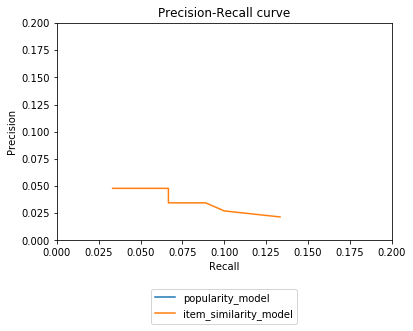

In [25]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")


### 더 큰 데이터 서브셋의 정밀도-재현율 곡선 생성하기 (파이썬 3)

Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).
Plotting precision recall curves.


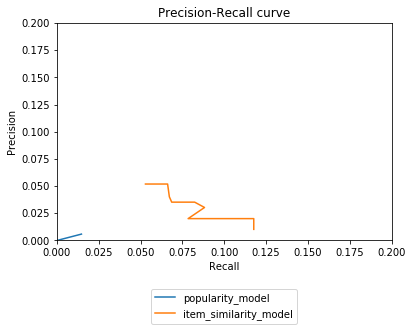

In [26]:
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

#이전 저장 파일을 읽어옵니다.
pm_avg_precision_list = joblib.load('pm_avg_precision_list_3.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_3.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_3.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_3.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

### 더 큰 데이터 서브셋의 정밀도-재현율 곡선 생성하기  (파이썬 2.7)

Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).
Plotting precision recall curves.


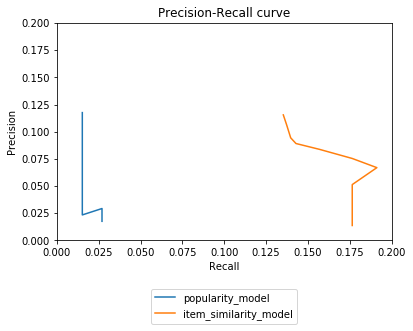

In [27]:
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

pm_avg_precision_list = joblib.load('pm_avg_precision_list_2.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_2.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_2.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_2.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

그래프를 통해 개인화된 모델이 유명도 모델보다 훨씬 나은 성능을 보여준다는 것을 알 수 있습니다.

# 행렬분해 기반 추천 시스템

SVD 행렬 분해를 기반으로 한 협업 필터링 추천 시스템을 사용합니다.
---

아래 코드는 특이값 분해(SVD)를 기반으로 한 행렬 분해 협업 필터링 추천 시스템입니다. 사용자 평점 행렬은 다음과 같습니다

||Item0|Item1|Item2|Item3|
|---|---|---|---|
|User0|3|1|2|3|
|User1|4|3|4|3|
|User2|3|2|1|5|
|User3|1|6|5|2|
|User4|0|0|5|0|

위 행렬에서 볼 수 있듯이, User4 를 제외하고는 모두가 아이템에 평점을 매겼습니다. 

이 코드에서 User4 에 대한 추천을 예측하여 계산합니다.

### 필요한 라이브러리 불러오기

In [28]:
#코드의 소스: 
#http://antoinevastel.github.io/machine%20learning/python/2016/02/14/svd-recommender-system.html

import math as mt
import csv
from sparsesvd import sparsesvd #행렬분해를 위해 사용됩니다.
import numpy as np
from scipy.sparse import csc_matrix #희소행렬을 위해 사용됩니다.
from scipy.sparse.linalg import * #행렬 곱셈을 위해 사용됩니다.

#참고: sparsesvd 라이브러리를 설치해야할 수도 있습니다.
#sparsesvd 메소드에 대한 다큐먼트는 이곳에 있습니다:
#https://pypi.python.org/pypi/sparsesvd/

ImportError: No module named 'sparsesvd'

### SVD 와 추천을 계산할 메소드

In [ ]:
#사용자 평점 행렬(URM)의 차원을 정의할 상수
MAX_PID = 4
MAX_UID = 5

#사용자 평점 행렬의 SVD 를 계산합니다.
def computeSVD(urm, K):
    U, s, Vt = sparsesvd(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(np.transpose(U), dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

#테스트 사용자를 위한 예상 평점을 계산합니다.
def computeEstimatedRatings(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 

    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        #벡터를 dense format 으로 변환하여
        #최고 예상 평점을 가진 영화를 찾아냅니다.
        estimatedRatings[userTest, :] = prod.todense()
        recom = (-estimatedRatings[userTest, :]).argsort()[:250]
    return recom


### SVD 를 이용해 User4 예측하기

In [ ]:
#SVD 계산에 사용될 것입니다 (잠재 인수의 개수).
K=2

#샘플 사용자 평점 행렬을 초기화합니다.
urm = np.array([[3, 1, 2, 3],[4, 3, 4, 3],[3, 2, 1, 5], [1, 6, 5, 2], [5, 0,0 , 0]])
urm = csc_matrix(urm, dtype=np.float32)

#입력된 사용자 평점 행렬의 SVD 를 계산합니다.
U, S, Vt = computeSVD(urm, K)

#테스트 사용자의 사용자 ID 를 4로, 평점을 [0, 0, 5, 0]으로 설정합니다.
uTest = [4]
print("User id for whom recommendations are needed: %d" % uTest[0])

#테스트 사용자에 대한 예상 평점
print("Predictied ratings:")
uTest_recommended_items = computeEstimatedRatings(urm, U, S, Vt, uTest, K, True)
print(uTest_recommended_items)

### 퀴즈 4

a.) 테스트 사용자 4의 평점 행렬을 다음과 같이 바꾸었을 때, 예측되는 추천의 차이를 말하시오

i.) [5 0 0 0]


(참고: 코드를 통한 예상 평점에 사용자가 이미 매긴 평점도 남겨져있는데, 이는SVD 에 대한 더 깊은 이해를 위해 의도적으로 둔 것입니다.).

SVD 튜토리얼: http://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm

## SVD 직관적으로 이해하기

SVD 의 결과는 3 개의 행렬입니다: U, S, 와 Vt (Vt 에서 t 는 전치행렬을 의미합니다). 

U 행렬은 사용자 벡터를 의미하고,  Vt 행렬을 아이템 벡터를 의미합니다.

U 는 사용자를 잠재 벡터 공간에서의 2차원 점으로 표현하고, Vt 는 같은 공간에서 아이템을 2차원 점으로 표현합니다.


다음으로는 U, S, 와 Vt 행렬을 출력하고 해석해볼 것입니다. 

사용자와 아이템의 점이 2차원 축에서 어떻게 나타날지 생각해봅시다. 

예를 들면, 다음 코드는 2차원 공간에서 U 행렬의 모든 사용자 벡터를 표시합니다. 동일하게, Vt 행렬로부터 모든 아이템 벡터를 표시합니다.


In [ ]:
%matplotlib inline
from pylab import *

#모든 사용자를 표시합니다.
print("Matrix Dimensions for U")
print(U.shape)

for i in range(0, U.shape[0]):
    plot(U[i,0], U[i,1], marker = "*", label="user"+str(i))

for j in range(0, Vt.T.shape[0]):
    plot(Vt.T[j,0], Vt.T[j,1], marker = 'd', label="item"+str(j))    
    
legend(loc="upper right")
title('User vectors in the Latent semantic space')
ylim([-0.7, 0.7])
xlim([-0.7, 0])
show()